In [279]:
import pandas as pd
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skdat
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [280]:
import wbgapi as wb

# list of country codes from three different continents are choosen
country_codes = ['CAN', 'DEU', 'IRL', 'JPN', 'PRT', 'GBR', 'USA', 'VNM', 'IND', 'KOR', 'MEX']

"""
From Climate Change category:
- Total greenhouse gas emissions (kt of CO2 equivalent)
- Methane emissions (kt of CO2 equivalent)
"""
indicator_ids = ['EN.ATM.GHGT.KT.CE', 'EN.ATM.METH.KT.CE']
indicators = {
    'EN.ATM.GHGT.KT.CE':'Total greenhouse gas emissions (kt of CO2 equivalent)',
    'EN.ATM.METH.KT.CE':'Methane emissions (kt of CO2 equivalent)'
}
wbdf = wb.data.DataFrame(indicator_ids, country_codes, time=range(2008, 2018))

miindex = pd.MultiIndex.from_product([country_codes, [x.replace("YR", "") for x in wbdf.columns]], names=["country", "year"])
column_tup = ['Total greenhouse gas emissions (kt of CO2 equivalent)', 'Methane emissions (kt of CO2 equivalent)']
df = pd.DataFrame(0, index=miindex, columns=column_tup)

for index, row in wbdf.iterrows():
    for x, y in row.items():
        df.loc[(index[0], x.replace("YR", "")), df.columns.get_level_values(0)==indicators[index[1]]] = y
    
df

Total greenhouse gas emissions (kt of CO2 equivalent)  \
country year                                                          
CAN     2008                                             698190       
        2009                                             661010       
        2010                                             674200       
        2011                                             689760       
        2012                                             694210       
...                                                         ...       
MEX     2013                                             652690       
        2014                                             645940       
        2015                                             670100       
        2016                                             682910       
        2017                                             678120       

              Methane emissions (kt of CO2 equivalent)  
country year                                            
CAN     2008                                     96350  
        2009                                     91740  
        2010                                     90200  
        2011                                     90120  
        2012                                     92550  
...                                                ...  
MEX     2013                                    122230  
        2014                                    131150  
        2015                                    140460  
        2016                                    141710  
        2017                                    143310  

[110 rows x 2 columns]

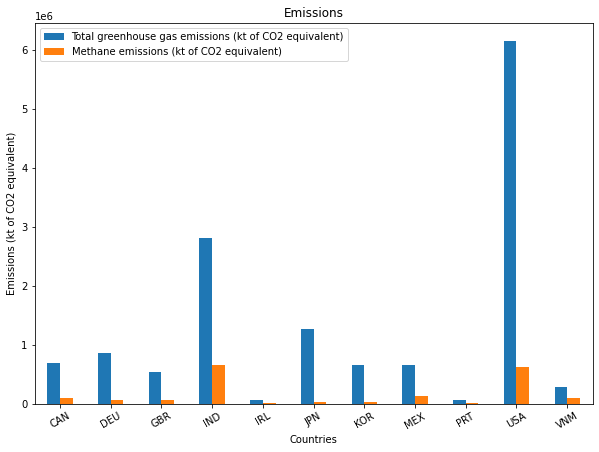

In [281]:
# plotting mean of total greenhouse gas emission and methane emission
l = df.groupby(['country']).mean()
l.plot.bar(figsize=(10, 7))
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Emissions")
plt.xlabel("Countries")
plt.ylabel("Emissions (kt of CO2 equivalent)")
plt.savefig("1.pdf")

In [282]:
# splitting into x and y and as pairs
xy = df.iloc[:, [0,1]].values
x = xy[:,0]
y = xy[:,1]

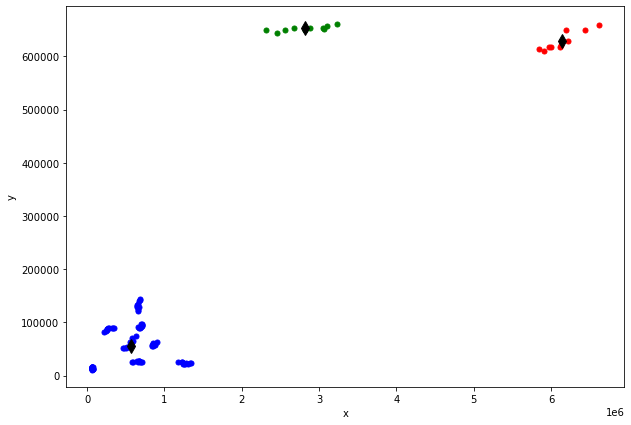

In [283]:
# Clustering
import sklearn.cluster as cluster

kmeans = cluster.KMeans(n_clusters=3)

# Fit the data, results are stored in the kmeans object
kmeans.fit(xy) 
labels = kmeans.labels_
# extract the estimated cluster centres
cen = kmeans.cluster_centers_
# print(cen)

# plot using the labels to select colour
plt.figure(figsize=(10,7))
col = ["blue", "red", "green"]
for l in range(0,3): 
    plt.plot(x[labels==l], y[labels==l], "o", markersize=5, color=col[l])

for ic in range(3):
    xc, yc = cen[ic,:]
    plt.plot(xc, yc, "dk", markersize=10)
    
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [284]:
print(kmeans.predict([[3000000, 600000]]))

[2]


In [285]:
print(kmeans.predict([[300000, 600000]]))

[0]


In [286]:
# functions for fitting
def exp_growth(t, scale, growth):
    """ Computes exponential function with scale and growth as free parameters
    """
    f = scale * np.exp(growth * (t-1950))
    return f

def logistics(t, scale, growth, t0):
    """ Computes logistics function with scale, growth raat
    and time of the turning point as free parameters
    """
    f = scale / (1.0 + np.exp(-growth * (t - t0)))
    return f

def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper

In [287]:
df.reset_index(inplace=True)

In [288]:
df['year'] = pd.to_datetime(df['year'])
df['year'] = pd.DatetimeIndex(df['year']).year

In [289]:
df = df.loc[df['country']=='GBR']
df.reset_index(drop=True, inplace=True)
df

,country,year,Total greenhouse gas emissions (kt of CO2 equivalent),Methane emissions (kt of CO2 equivalent)
0,GBR,2008,636520,74840
1,GBR,2009,581690,70630
2,GBR,2010,594560,65750
3,GBR,2011,551940,63080
4,GBR,2012,573410,61440
5,GBR,2013,554670,56720
6,GBR,2014,513800,53780
7,GBR,2015,497740,52150
8,GBR,2016,475240,52050
9,GBR,2017,461190,51630


In [290]:
# fit exponential growth
popt, covar = opt.curve_fit(exp_growth, df["year"],
df["Methane emissions (kt of CO2 equivalent)"])

Fit parameter [3.05816152e-14 1.00000001e+00]


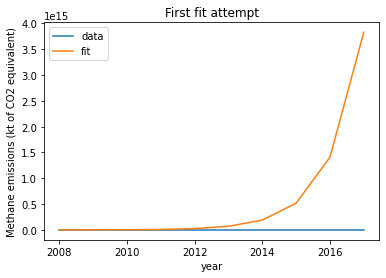

In [291]:
print("Fit parameter", popt)
# use *popt to pass on the fit parameters
df["pop_exp"] = exp_growth(df["year"], *popt)
plt.figure()
plt.plot(df["year"], df["Methane emissions (kt of CO2 equivalent)"], label="data")
plt.plot(df["year"], df["pop_exp"], label="fit")
plt.legend()
plt.title("First fit attempt")
plt.xlabel("year")
plt.ylabel("Methane emissions (kt of CO2 equivalent)")
plt.show()

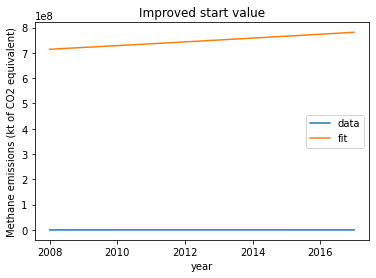

In [292]:
popt = [4e8, 0.01]
df["pop_exp"] = exp_growth(df["year"], *popt)
plt.figure()
plt.plot(df["year"], df["Methane emissions (kt of CO2 equivalent)"], label="data")
plt.plot(df["year"], df["pop_exp"], label="fit")
plt.legend()
plt.xlabel("year")
plt.ylabel("Methane emissions (kt of CO2 equivalent)")
plt.title("Improved start value")
plt.show()


Fit parameter [ 1.00971791e+06 -4.52516141e-02]


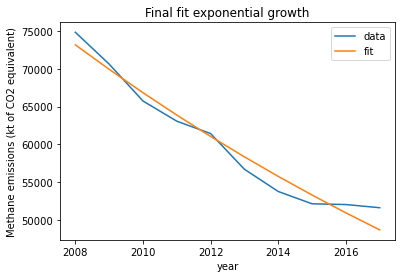

In [293]:
popt, covar = opt.curve_fit(exp_growth, df["year"], df["Methane emissions (kt of CO2 equivalent)"], p0=[4e8, 0.02])
print("Fit parameter", popt)
df["pop_exp"] = exp_growth(df["year"], *popt)
plt.figure()
plt.plot(df["year"], df["Methane emissions (kt of CO2 equivalent)"], label="data")
plt.plot(df["year"], df["pop_exp"], label="fit")
plt.legend()
plt.xlabel("year")
plt.ylabel("Methane emissions (kt of CO2 equivalent)")
plt.title("Final fit exponential growth")
plt.show()

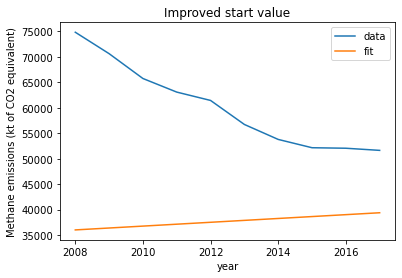

In [294]:
# Finding a start approximation for the logistics function
popt = [75000, 0.02, 2012]
df["pop_log"] = logistics(df["year"], *popt)
plt.figure()
plt.plot(df["year"], df["Methane emissions (kt of CO2 equivalent)"], label="data")
plt.plot(df["year"], df["pop_log"], label="fit")
plt.legend()
plt.xlabel("year")
plt.ylabel("Methane emissions (kt of CO2 equivalent)")
plt.title("Improved start value")
plt.show()

Fit parameter [6.0207e+04 1.0000e+00 1.0000e+00]


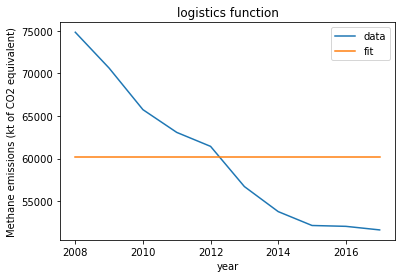

In [295]:
popt, covar = opt.curve_fit(logistics, df["year"], df["Methane emissions (kt of CO2 equivalent)"])
print("Fit parameter", popt)
df["pop_log"] = logistics(df["year"], *popt)
plt.figure()
plt.title("logistics function")
plt.plot(df["year"], df["Methane emissions (kt of CO2 equivalent)"], label="data")
plt.plot(df["year"], df["pop_log"], label="fit")
plt.legend()
plt.xlabel("year")
plt.ylabel("Methane emissions (kt of CO2 equivalent)")
plt.show()

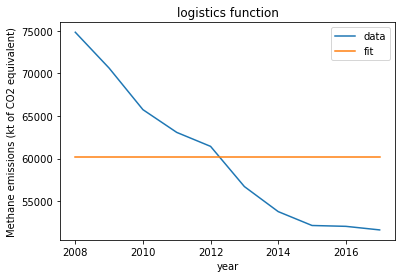

In [297]:
# extract the sigmas from the diagonal of the covariance matrix
sigma = np.sqrt(np.diag(covar))
low, up = err_ranges(df["year"], logistics, popt, sigma)
plt.figure()
plt.title("logistics function")
plt.plot(df["year"], df["Methane emissions (kt of CO2 equivalent)"], label="data")
plt.plot(df["year"], df["pop_log"], label="fit")
plt.fill_between(df["year"], low, up, alpha=0.7)
plt.legend()
plt.xlabel("year")
plt.ylabel("Methane emissions (kt of CO2 equivalent)")
plt.show()
